# Importar librerias

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
 
from tensorflow.keras.preprocessing import image

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, concatenate, MaxPooling2D, AveragePooling2D, Conv1D, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparaciónn de data

## cargar data

In [2]:
meta_data = pd.read_excel('data_preliminar_trabajo_de_grado.Xlsx')
labels= meta_data['id_referencia'].unique()
labels_train = [str(x) for x in labels ]
train= ImageDataGenerator() \
.flow_from_directory(directory='data_tg_fase1 - copia/train',target_size=(512, 512), classes=labels_train, batch_size=1)

Found 250 images belonging to 125 classes.


In [3]:
#separamos el tensor de la imagen del tensor de cladificación
x_train = []
y_train = []
labels_train = []

for i in range (0, len(train.labels)):
    x = np.squeeze(train[i][0])
    x_train.append(x)
    
    y = np.squeeze(train[i][1])
    y_train.append(y)
    
    labels = y.tolist()
    labels = labels.index(1)
    labels_train.append(labels)
    
x_train = np.array(x_train)
print(x_train.shape)
y_train = np.array(y_train)
print(y_train.shape)
labels_train = np.array(labels_train)
print(labels_train.shape)
    

(250, 512, 512, 3)
(250, 125)
(250,)


In [4]:
# creación función para graficar las tripletas 
def plot_triplet (triplet):
        plt.figure(figsize=(6, 2))
        for i in range (0, 3):
            plt.subplot(1, 3, i + 1  )
            plt.imshow(np.squeeze((triplet[i].astype('uint8'))))
            plt.xticks=([])
            plt.yticks([])
            plt.show()    
    

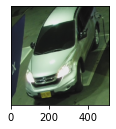

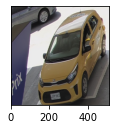

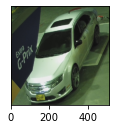

In [5]:
# prueba funcionamiento del plot_triplet
plot_triplet([x_train[0], x_train[1], x_train[2]])

In [6]:
#creación de la función para generar las tripletas
def create_batch (batch_size=1, counter=0):
    anchors = np.zeros((batch_size, 512, 512, 3))
    positives = np.zeros((batch_size, 512, 512, 3))
    negatives = np.zeros((batch_size, 512, 512, 3))
    yy_train = np.zeros((batch_size, 125 ))
    
    for i in range(0, batch_size):
        #index = random.randint(0, len(train.labels) - 1)
        anc = x_train[counter]
        #print(anc.shape)
        yy = y_train[counter]
        #print(yy.shape)
        y = labels_train[counter]
        
        indices_for_pos = np.squeeze(np.where(labels_train == y))
        #print(indices_for_pos[0:5])
        indices_for_neg = np.squeeze(np.where(labels_train != y))
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
    
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        yy_train[i] = yy
            
    return [anchors, positives, negatives, yy_train]

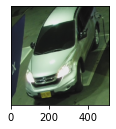

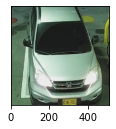

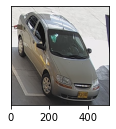

In [7]:
# graficación de una tripleta
triplet = create_batch(1)[:3]
plot_triplet(triplet)

## data set de entrenamiento

In [17]:
#función para crear el data set de entrenamiento
def data_generator (batch_size = 1, emb_dim=125):
    counter = 0
    while True:
        x = create_batch(batch_size, counter)[:3]
        y = create_batch(batch_size, counter)[-1]
        if counter < len(train.labels)-1 :
            counter = counter + 1
        else:
            counter = 0
        yield x, y

# Función de perdida triplet loss

In [16]:
def triplet_loss (alpha=0.3, poolsize=125):
    def loss (y_true, y_pred):
        anc, pos, neg = y_pred[:, :poolsize], y_pred[:, poolsize:2*poolsize], y_pred[:, 2*poolsize:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

# Modelado

## embeding models

### complementary branch _2_3

In [8]:
# red pool_size 8X8
emb_dims = 125

in_emb =  Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_emb)

mp = MaxPooling2D(pool_size= (8, 8), strides= 8)(rn50)
bn1 = BatchNormalization()(mp)

ap = AveragePooling2D(pool_size= (8, 8), strides= 8)(rn50)
bn2 = BatchNormalization()(ap)

suma = Add()([bn1, bn2])

bn3 = BatchNormalization()(suma)
acti = Activation('relu')(bn3)
conv1 = Conv2D(filters= 256, kernel_size= (1, 1))(acti)
bnconv = BatchNormalization()(conv1)

flat = Flatten()(bnconv)
dense125 = Dense(units=emb_dims, activation='softmax')(flat)

embeding_model_cb2 = Model(in_emb, dense125)

embeding_model_cb2.summary()
      

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 2, 2, 2048)   0           ['resnet50[0][0]']               
                                                                                              

In [9]:
# red pool_seze 4X4
emb_dims = 125

in_emb =  Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_emb)

mp = MaxPooling2D(pool_size= (4, 4), strides= 4)(rn50)
bn1 = BatchNormalization()(mp)

ap = AveragePooling2D(pool_size= (4, 4), strides= 4)(rn50)
bn2 = BatchNormalization()(ap)

suma = Add()([bn1, bn2])

bn3 = BatchNormalization()(suma)
acti = Activation('relu')(bn3)
conv1 = Conv2D(filters= 256, kernel_size= (1, 1))(acti)
bnconv = BatchNormalization()(conv1)

flat = Flatten()(bnconv)
dense125 = Dense(units=emb_dims, activation='softmax')(flat)

embeding_model_cb3 = Model(in_emb, dense125)

embeding_model_cb3.summary()
      

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 4, 4, 2048)  0           ['resnet50[0][0]']               
                                                                                            

In [10]:
#red pool_size 16X16
emb_dims = 125

in_emb =  Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_emb)

mp = MaxPooling2D(pool_size= (16, 16), strides= 16)(rn50)
bn1 = BatchNormalization()(mp)

ap = AveragePooling2D(pool_size= (16, 16), strides= 16)(rn50)
bn2 = BatchNormalization()(ap)

suma = Add()([bn1, bn2])

bn3 = BatchNormalization()(suma)
acti = Activation('relu')(bn3)
conv1 = Conv2D(filters= 256, kernel_size= (1, 1))(acti)
bnconv = BatchNormalization()(conv1)

flat = Flatten()(bnconv)
dense125 = Dense(units=emb_dims, activation='softmax')(flat)

embeding_model_cb4 = Model(in_emb, dense125)

embeding_model_cb4.summary()
      

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 1, 1, 2048)  0           ['resnet50[0][0]']               
                                                                                            

In [11]:
#red pool_size 2X2
emb_dims = 125

in_emb =  Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_emb)

mp = MaxPooling2D(pool_size= (2, 2), strides= 2)(rn50)
bn1 = BatchNormalization()(mp)

ap = AveragePooling2D(pool_size= (2, 2), strides= 2)(rn50)
bn2 = BatchNormalization()(ap)

suma = Add()([bn1, bn2])

bn3 = BatchNormalization()(suma)
acti = Activation('relu')(bn3)
conv1 = Conv2D(filters= 256, kernel_size= (1, 1))(acti)
bnconv = BatchNormalization()(conv1)

flat = Flatten()(bnconv)
dense125 = Dense(units=emb_dims, activation='softmax')(flat)
#print(dense125.shape)

embeding_model_cb5 = Model(in_emb, dense125)

embeding_model_cb5.summary()
      

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 2048)  0           ['resnet50[0][0]']               
                                                                                            

## siameses networks

### complementary branch_2_3 

In [12]:
# red siames pool_size8X8
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))

emb_anc = embeding_model_cb2(in_anc)
emb_pos = embeding_model_cb2(in_pos)
emb_neg = embeding_model_cb2(in_neg)

emb_conca = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

net_cb2 =  Model ([in_anc, in_pos, in_neg], [emb_conca, emb_anc])

net_cb2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                          

In [13]:
# red siames pool_size 4X4
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))

emb_anc = embeding_model_cb3(in_anc)
emb_pos = embeding_model_cb3(in_pos)
emb_neg = embeding_model_cb3(in_neg)

emb_conca = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

net_cb3 =  Model ([in_anc, in_pos, in_neg], [emb_conca, emb_anc])

net_cb3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_13 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                          

In [14]:
# redsiames pool_size 16X16
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))

emb_anc = embeding_model_cb4(in_anc)
emb_pos = embeding_model_cb4(in_pos)
emb_neg = embeding_model_cb4(in_neg)

emb_conca = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

net_cb4 =  Model ([in_anc, in_pos, in_neg], [emb_conca, emb_anc])

net_cb4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_13 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                          

In [15]:
# red siames pool_size 2X2
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))

emb_anc = embeding_model_cb5(in_anc)
emb_pos = embeding_model_cb5(in_pos)
emb_neg = embeding_model_cb5(in_neg)

emb_conca = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

net_cb5 =  Model ([in_anc, in_pos, in_neg], [emb_conca, emb_anc])

net_cb5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_19 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_20 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                          

## entrenamiento

### complementary branch_2_3

In [18]:
#entrenamiento red pool_size 8X8
batch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_cb2.compile(loss=[triplet_loss(alpha=0.3, poolsize=125), 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [19]:
net_cb2.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 1127s 4s/step - loss: 7.1580 - concatenate_loss: 0.2990 - model_loss: 6.8590 - concatenate_accuracy: 0.0040 - model_accuracy: 0.0040
Epoch 2/15
250/250 [==============================] - 1063s 4s/step - loss: 7.4399 - concatenate_loss: 0.2989 - model_loss: 7.1410 - concatenate_accuracy: 0.0000e+00 - model_accuracy: 0.0040
Epoch 3/15
250/250 [==============================] - 1070s 4s/step - loss: 7.5444 - concatenate_loss: 0.2992 - model_loss: 7.2453 - concatenate_accuracy: 0.0000e+00 - model_accuracy: 0.0040
Epoch 4/15
250/250 [==============================] - 1055s 4s/step - loss: 6.9777 - concatenate_loss: 0.2991 - model_loss: 6.6787 - concatenate_accuracy: 0.0040 - model_accuracy: 0.0080
Epoch 5/15
250/250 [==============================] - 1068s 4s/step - loss: 6.8536 - concatenate_loss: 0.2992 - model_loss: 6.5543 - concatenate_accuracy: 0.0040 - model_accuracy: 0.0080
Epoch 6/15
250/250 [==============================] - 104

In [20]:
# entrenamiento red pool_size 4X4
batch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_cb3.compile(loss=[triplet_loss(alpha=0.3, poolsize=125), 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [21]:
net_cb3.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 1056s 4s/step - loss: 10.6539 - concatenate_1_loss: 0.2962 - model_1_loss: 10.3577 - concatenate_1_accuracy: 0.0040 - model_1_accuracy: 0.0080
Epoch 2/15
250/250 [==============================] - 1039s 4s/step - loss: 13.1148 - concatenate_1_loss: 0.2966 - model_1_loss: 12.8183 - concatenate_1_accuracy: 0.0040 - model_1_accuracy: 0.0080
Epoch 3/15
250/250 [==============================] - 1038s 4s/step - loss: 12.4494 - concatenate_1_loss: 0.2959 - model_1_loss: 12.1535 - concatenate_1_accuracy: 0.0000e+00 - model_1_accuracy: 0.0000e+00
Epoch 4/15
250/250 [==============================] - 1037s 4s/step - loss: 11.2102 - concatenate_1_loss: 0.2966 - model_1_loss: 10.9135 - concatenate_1_accuracy: 0.0000e+00 - model_1_accuracy: 0.0040
Epoch 5/15
250/250 [==============================] - 1037s 4s/step - loss: 9.5865 - concatenate_1_loss: 0.2966 - model_1_loss: 9.2899 - concatenate_1_accuracy: 0.0000e+00 - model_1_accuracy: 0.0000e+

In [22]:
# entrenamiento red pool_size 16X16
atch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_cb4.compile(loss=[triplet_loss(alpha=0.3, poolsize=125), 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

net_cb4.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 1069s 4s/step - loss: 5.1546 - concatenate_2_loss: 0.3000 - model_2_loss: 4.8546 - concatenate_2_accuracy: 0.0000e+00 - model_2_accuracy: 0.0000e+00
Epoch 2/15
250/250 [==============================] - 1025s 4s/step - loss: 5.1562 - concatenate_2_loss: 0.3000 - model_2_loss: 4.8562 - concatenate_2_accuracy: 0.0000e+00 - model_2_accuracy: 0.0000e+00
Epoch 3/15
250/250 [==============================] - 1033s 4s/step - loss: 5.1571 - concatenate_2_loss: 0.3000 - model_2_loss: 4.8571 - concatenate_2_accuracy: 0.0000e+00 - model_2_accuracy: 0.0000e+00
Epoch 4/15
250/250 [==============================] - 1042s 4s/step - loss: 5.1577 - concatenate_2_loss: 0.3000 - model_2_loss: 4.8577 - concatenate_2_accuracy: 0.0000e+00 - model_2_accuracy: 0.0000e+00
Epoch 5/15
250/250 [==============================] - 1027s 4s/step - loss: 5.1585 - concatenate_2_loss: 0.3000 - model_2_loss: 4.8585 - concatenate_2_accuracy: 0.0000e+00 - model_2_accura

In [23]:
# entrenamiento red pool_size 2X2
atch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_cb5.compile(loss=[triplet_loss(alpha=0.3, poolsize=125), 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

net_cb5.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 1096s 4s/step - loss: 20.9510 - concatenate_3_loss: 0.2940 - model_3_loss: 20.6570 - concatenate_3_accuracy: 0.0040 - model_3_accuracy: 0.0080
Epoch 2/15
250/250 [==============================] - 1049s 4s/step - loss: 23.1536 - concatenate_3_loss: 0.2933 - model_3_loss: 22.8604 - concatenate_3_accuracy: 0.0000e+00 - model_3_accuracy: 0.0040
Epoch 3/15
250/250 [==============================] - 1133s 5s/step - loss: 20.4886 - concatenate_3_loss: 0.2944 - model_3_loss: 20.1942 - concatenate_3_accuracy: 0.0000e+00 - model_3_accuracy: 0.0000e+00
Epoch 4/15
250/250 [==============================] - 1148s 5s/step - loss: 17.3134 - concatenate_3_loss: 0.2946 - model_3_loss: 17.0187 - concatenate_3_accuracy: 0.0080 - model_3_accuracy: 0.0080
Epoch 5/15
250/250 [==============================] - 1101s 4s/step - loss: 12.4442 - concatenate_3_loss: 0.2953 - model_3_loss: 12.1489 - concatenate_3_accuracy: 0.0080 - model_3_accuracy: 0.0240
Epo

## costrucción de modelo

### global brach

In [26]:
# construcción red pool_size 16X16
final_dim = 125

in_anc = Input(shape= (512, 512, 3))
in_pos = Input(shape= (512, 512, 3))
in_neg = Input(shape= (512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)

ap = AveragePooling2D(pool_size= (16, 16), strides= 16)(rn50)
bn = BatchNormalization()(ap)
acti = Activation('relu')(bn)
conv1 = Conv2D(filters= 256, kernel_size= (1,1))(acti)
        
flatten = Flatten()(conv1)
dense125 = Dense(units= final_dim, activation='softmax')(flatten)

net_g1 = Model([in_anc, in_pos, in_neg], dense125)

net_g1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 average_pooling2d_5 (AveragePo  (None, 1, 1, 2048)  0           ['resnet50[0][0]']               
 oling2D)                                                                                   

In [36]:
# entrenamiento de red pool_size 8X8
atch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_g1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_g1.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 397s 2s/step - loss: 4.8341 - accuracy: 0.0040
Epoch 2/15
250/250 [==============================] - 386s 2s/step - loss: 4.8573 - accuracy: 0.0040
Epoch 3/15
250/250 [==============================] - 385s 2s/step - loss: 4.8629 - accuracy: 0.0000e+00
Epoch 4/15
250/250 [==============================] - 383s 2s/step - loss: 4.8670 - accuracy: 0.0000e+00
Epoch 5/15
250/250 [==============================] - 383s 2s/step - loss: 4.8702 - accuracy: 0.0000e+00
Epoch 6/15
250/250 [==============================] - 407s 2s/step - loss: 4.8722 - accuracy: 0.0000e+00
Epoch 7/15
250/250 [==============================] - 387s 2s/step - loss: 4.8729 - accuracy: 0.0000e+00
Epoch 8/15
250/250 [==============================] - 379s 2s/step - loss: 4.8722 - accuracy: 0.0000e+00
Epoch 9/15
250/250 [==============================] - 379s 2s/step - loss: 4.8705 - accuracy: 0.0040
Epoch 10/15
250/250 [==============================] - 376s 2s/step

In [37]:
# construcción red pool_size 8X8
final_dim = 125

in_anc = Input(shape= (512, 512, 3))
in_pos = Input(shape= (512, 512, 3))
in_neg = Input(shape= (512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)

ap = AveragePooling2D(pool_size= (8, 8), strides= 8)(rn50)
bn = BatchNormalization()(ap)
acti = Activation('relu')(bn)
conv1 = Conv2D(filters= 256, kernel_size= (1,1))(acti)
        
flatten = Flatten()(conv1)
dense125 = Dense(units= final_dim, activation='softmax')(flatten)

net_g2 = Model([in_anc, in_pos, in_neg], dense125)

net_g2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 average_pooling2d_6 (AveragePo  (None, 2, 2, 2048)  0           ['resnet50[0][0]']               
 oling2D)                                                                                  

In [38]:
# entrenamiento red pool_size 8X8
bh_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_g2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_g2.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 419s 2s/step - loss: 10.8299 - accuracy: 0.0000e+00
Epoch 2/15
250/250 [==============================] - 395s 2s/step - loss: 7.4035 - accuracy: 0.0000e+00
Epoch 3/15
250/250 [==============================] - 397s 2s/step - loss: 6.3695 - accuracy: 0.0000e+00
Epoch 4/15
250/250 [==============================] - 395s 2s/step - loss: 5.8203 - accuracy: 0.0000e+00
Epoch 5/15
250/250 [==============================] - 394s 2s/step - loss: 5.4247 - accuracy: 0.0000e+00
Epoch 6/15
250/250 [==============================] - 395s 2s/step - loss: 5.1843 - accuracy: 0.0000e+00
Epoch 7/15
250/250 [==============================] - 395s 2s/step - loss: 4.9962 - accuracy: 0.0040
Epoch 8/15
250/250 [==============================] - 396s 2s/step - loss: 5.1623 - accuracy: 0.0080
Epoch 9/15
250/250 [==============================] - 391s 2s/step - loss: 4.8007 - accuracy: 0.0040
Epoch 10/15
250/250 [==============================] - 390s 2s/ste

In [39]:
# construcción red pool_size 4X4
final_dim = 125

in_anc = Input(shape= (512, 512, 3))
in_pos = Input(shape= (512, 512, 3))
in_neg = Input(shape= (512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)

ap = AveragePooling2D(pool_size= (4, 4), strides= 4)(rn50)
bn = BatchNormalization()(ap)
acti = Activation('relu')(bn)
conv1 = Conv2D(filters= 256, kernel_size= (1,1))(acti)
        
flatten = Flatten()(conv1)
dense125 = Dense(units= final_dim, activation='softmax')(flatten)

net_g3 = Model([in_anc, in_pos, in_neg], dense125)

net_g3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_33[0][0]']               
                                )                                                                 
                                                                                                  
 average_pooling2d_7 (AveragePo  (None, 4, 4, 2048)  0           ['resnet50[0][0]']               
 oling2D)                                                                                  

In [40]:
# entrenamiento red pool size 4X4
batch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_g3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_g3.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 404s 2s/step - loss: 20.4125 - accuracy: 0.0000e+00
Epoch 2/15
250/250 [==============================] - 392s 2s/step - loss: 18.2955 - accuracy: 0.0000e+00
Epoch 3/15
250/250 [==============================] - 396s 2s/step - loss: 13.7061 - accuracy: 0.0080
Epoch 4/15
250/250 [==============================] - 391s 2s/step - loss: 13.5989 - accuracy: 0.0800
Epoch 5/15
250/250 [==============================] - 392s 2s/step - loss: 10.4071 - accuracy: 0.1800
Epoch 6/15
250/250 [==============================] - 393s 2s/step - loss: 11.6494 - accuracy: 0.3560
Epoch 7/15
250/250 [==============================] - 390s 2s/step - loss: 9.6861 - accuracy: 0.4160
Epoch 8/15
250/250 [==============================] - 390s 2s/step - loss: 7.1525 - accuracy: 0.4960
Epoch 9/15
250/250 [==============================] - 392s 2s/step - loss: 3.4760 - accuracy: 0.6240
Epoch 10/15
250/250 [==============================] - 392s 2s/step - loss: 3

In [41]:
# creación red pool_size 2X2
final_dim = 125

in_anc = Input(shape= (512, 512, 3))
in_pos = Input(shape= (512, 512, 3))
in_neg = Input(shape= (512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)

ap = AveragePooling2D(pool_size= (2, 2), strides= 2)(rn50)
bn = BatchNormalization()(ap)
acti = Activation('relu')(bn)
conv1 = Conv2D(filters= 256, kernel_size= (1,1))(acti)
        
flatten = Flatten()(conv1)
dense125 = Dense(units= final_dim, activation='softmax')(flatten)

net_g4 = Model([in_anc, in_pos, in_neg], dense125)

net_g4.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_37[0][0]']               
                                )                                                                 
                                                                                                  
 average_pooling2d_8 (AveragePo  (None, 8, 8, 2048)  0           ['resnet50[0][0]']               
 oling2D)                                                                                  

In [42]:
# entrenamiento red pool_size 2X2
batch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_g4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_g4.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 405s 2s/step - loss: 31.0205 - accuracy: 0.0000e+00
Epoch 2/15
250/250 [==============================] - 399s 2s/step - loss: 33.1441 - accuracy: 0.0120
Epoch 3/15
250/250 [==============================] - 396s 2s/step - loss: 42.0525 - accuracy: 0.0120
Epoch 4/15
250/250 [==============================] - 397s 2s/step - loss: 31.9945 - accuracy: 0.0800
Epoch 5/15
250/250 [==============================] - 399s 2s/step - loss: 25.3120 - accuracy: 0.1600
Epoch 6/15
250/250 [==============================] - 397s 2s/step - loss: 17.4365 - accuracy: 0.4240
Epoch 7/15
250/250 [==============================] - 399s 2s/step - loss: 8.9983 - accuracy: 0.6120
Epoch 8/15
250/250 [==============================] - 398s 2s/step - loss: 10.4296 - accuracy: 0.5920
Epoch 9/15
250/250 [==============================] - 398s 2s/step - loss: 7.9616 - accuracy: 0.7160
Epoch 10/15
250/250 [==============================] - 389s 2s/step - loss: 6.76